- GAIT ANALYSIS (Train/Test Split with Aggressive Oversampling and best model/paams from previous work)

- Dataset: As mentioned in notebook named 'gait_final_output_v1_1' 
    - Size: 48 samples (16 subjects * 3 trials)
    - Features: 321 gait measurements
    - Split: 68% train / 32% test => ~2 training + 1 test sample/class

- Data Credits: https://archive.ics.uci.edu/dataset/604/gait+classification

- Aim: Multi-class classification (16 subjects) using train/test split with aggressive oversampling strategy by creating sufficient samples for model training.

- KPIs:
    - Precision: Of all predicted positive, how many were actually positive?
    - Recall:    Of all actual positives,   how many did we find?
    - High recall is important if the cost of missing a target is extremely high. For example, in life-critical scenarios like preventing an accident or detecting a fugitive

- Pipeline
    - StandardScaler: Feature normalization
    - RandomOverSampler: Aggressive upsampling to 100 samples/class
    - SelectKBest: Keep top 3 features (min of 10, n_samples/10, sqrt(n_features))
    - KNeighborsClassifier: n_neighbors=2, weights='distance', metric='manhattan'

- Why This Approach Was Tested
    - Previous notebooks showed train/test split left too few training samples
    - Hypothesis: Aggressive oversampling might provide enough synthetic data
    - KNN chosen as best performer from GridSearchCV experiments

- Results:
    - Very poor performance
    - Perfect training accuracy (1.00 -> since only 2 samples/class -> model overfits) but low test accuracy
    - Many classes have 0.00 precision/recall
    - Model fails to generalize to unseen data

- Why This Failed
    - Oversampling Limitation
        - RandomOverSampler only duplicates existing samples
        - No new information added, just copies of the same 2 training samples/class
        - 100 copies of 2 samples NOT SAME AS 100 unique samples

    - Overfitting
        - Perfect training accuracy indicates model memorizes training duplicates but can't recognize real variation as shown by the low test accuracy (no generalization)
        - With only 1 test sample/class, evaluation is unreliable anyway

    - Feature Selection Too Aggressive
        - Reduces 321 features -> 3 features
        - May discard important discriminative information
        - Trades dimensionality reduction for information loss

- Better Alternatives:
    - Use all 48 samples for training (no split)
    - Keep more features (10-15) rather than only 3
    - SMOTE-based oversampling (creates synthetic samples via interpolation)
    - As mentioned in notebook named 'gait_final_output_v1_1' 

- Conclusion
    - Aggressive oversampling cannot overcome fundamental data scarcity. RandomOverSampler creates no new information—just duplicates.
    - The model achieves perfect training accuracy by memorizing duplicates but fails completely on new data.
    - This approach is inferior to using all 48 samples with proper cross-validation (as done in previous notebooks).


In [28]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, LeaveOneGroupOut, StratifiedKFold, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE

from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectKBest, mutual_info_classif

import optuna


In [29]:
# Load data
df = pd.read_csv('gait_final_output.csv')

print(f'df.shape: {df.shape}')

df.sample(3)

df.shape: (48, 322)


,Speed_R1,Variability_R1,Symmetry_R1,HeelPressTime_R1,CycleTime_R1,Cadence_R1,Posture_R1,Oscillation_R1,Loading_R1,FootPress_R1,...,P99_R3,P100_R3,P101_R3,P102_R3,P103_R3,P104_R3,P105_R3,P106_R3,P107_R3,Subject_ID_Y
40,1.39,0.00,-5.3,1.162,1.161,1.078,1.07,0.702,0.687,0.035,...,0.018,0.017,0.015,0.168,0.122,0.238,0.239,1.007,0.993,13
0,1.32,4.15,4.0,1.054,1.054,1.050,1.06,0.043,0.044,0.044,...,0.027,0.044,0.039,0.073,0.097,0.232,0.215,0.928,1.078,0
16,1.15,0.00,-0.7,1.264,1.211,1.140,1.14,0.737,0.412,0.070,...,0.025,0.052,0.038,0.039,0.080,0.204,0.213,0.937,1.067,5


In [30]:
# check for NA values
df.dtypes


Speed_R1            float64
Variability_R1      float64
Symmetry_R1         float64
HeelPressTime_R1    float64
CycleTime_R1        float64
                     ...   
P104_R3             float64
P105_R3             float64
P106_R3             float64
P107_R3             float64
Subject_ID_Y          int64
Length: 322, dtype: object

In [31]:
# check for NA values
df.isna().sum().sum()


np.int64(1)

In [32]:
# Get row with na value
row_index_of_na = df[ df.isna().any(axis=1) ].index[0]
print( type(row_index_of_na), '|' ,row_index_of_na.dtype)

col_name_of_na  = df.columns[  np.where( df.isna().any(axis=0) == True )[0][0]  ]

print("row_index_of_na:", row_index_of_na)
print("col_name_of_na:", col_name_of_na)


<class 'numpy.int64'> | int64
row_index_of_na: 43
col_name_of_na: CycleTime_R2


In [33]:
# Impute the NA value

# Since we have small number of rows, 48, and each 3 rows corresponds to 1 subject, we havae 16 subjects,
# the missing values comes from row subject 14's 2nd iteration, and column CycleTime_R2 (R1, R2, R3 are 
# three different sensors on the body).
# Therefore, it is appropriate to take median of CycleTime_R2 for imputing this value.


In [34]:
# median of CycleTime_R2 is 
print("Value BEFORE imputation:", df.loc[row_index_of_na, col_name_of_na] )

median_CycleTime_R2 = df[col_name_of_na].median()

df_new = df.copy()
    
df_new.loc[row_index_of_na, col_name_of_na] = median_CycleTime_R2

print("Value AFTER imputation:", df_new.loc[row_index_of_na, col_name_of_na] )


Value BEFORE imputation: nan
Value AFTER imputation: 6.15


In [35]:
# check NA values in the df_new dataframe
df_new.isna().sum().sum()


np.int64(0)

In [36]:
# Save this "df_new" as a new CSV file with name "gait_final_output_updated.csv"
# df_new.to_csv("gait_final_output_updated.csv", index=False)
# Update the data to 'Kaggle' and 'GitHub'

In [37]:
# Check for class imbalance
print(df_new['Subject_ID_Y'].value_counts().to_list())


[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [38]:
# STEP 0: Split X and y

y =  df_new['Subject_ID_Y']
X =  df_new.drop('Subject_ID_Y', axis='columns')


In [39]:
print(f"Total samples: {len(y)}")
print(f"Total features: {X.shape[1]}")
print(f"Number of classes: {len(y.unique())}")
print(f"\nClass distribution in full dataset:")
print(y.value_counts().sort_index().to_list())


Total samples: 48
Total features: 321
Number of classes: 16

Class distribution in full dataset:
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [40]:
# STEP 1: Test train split

X_train, X_test, y_train, y_test = \
    train_test_split( X, y, stratify=y, test_size=0.32, random_state=42 )

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

print(f"\nTraining samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")


X_train.shape: (32, 321)
X_test.shape: (16, 321)
y_train.shape: (32,)
y_test.shape: (16,)

Training samples: 32
Test samples: 16


In [41]:
# CHEKCK THE SPLIT

print("Training set distribution")
print( pd.Series( y_train ).value_counts().sort_index().to_list() )
print("------- ")

print("Test set distribution")
print( pd.Series( y_test ).value_counts().sort_index().to_list() )


Training set distribution
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
------- 
Test set distribution
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [42]:
# STEP 2: Define pipeline

target_samples_per_class = 100 # AGRESSIVE OVERSAMPLING

# Recommendation: Use fewer features to reduce overfitting
# Rule of thumb: k <= sqrt(n_features) or k <= n_samples/10
# min(10, X.shape[1], len(X) // 10)
print(f"10 | {len(X_train)//10} | {int(np.sqrt(X.shape[1]))}")
max_k = min(10, len(X_train)//10 , int(np.sqrt(X.shape[1])) )
print("max_k:", max_k)

pipeline = Pipeline([
    ( 'scaler'          , StandardScaler() ),
    ( 'over_sampler'    , RandomOverSampler(
            random_state      = 42,
            sampling_strategy = {cls: target_samples_per_class for cls in np.unique(y_train)}
        )  
    ),
    ( 'feature_selector', SelectKBest(mutual_info_classif, k=max_k) ),
    ( 'model'           , KNeighborsClassifier(
        n_neighbors=2,  
        weights='distance', 
        algorithm='auto', 
        leaf_size=30, 
        p=2, 
        metric='manhattan', 
        metric_params=None, 
        n_jobs=-1) )  
])
# model uses the optimal model and optimal params obtained previously


10 | 3 | 17
max_k: 3


In [43]:
# Train the oversampled data
pipeline.fit(X_train, y_train) #  this is the step utilizing the oversampling performed in the previous step

# Evaluate
train_accuracy = pipeline.score(X_train, y_train) # runs on the actual un-oversampled data
test_accuracy = pipeline.score(X_test, y_test)    # runs on the actual un-oversampled data

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Training Accuracy: 1.0000
Test Accuracy: 0.1250


=======CLASSIFICATION REPORT ==============
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.50      1.00      0.67         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1

    accuracy                        

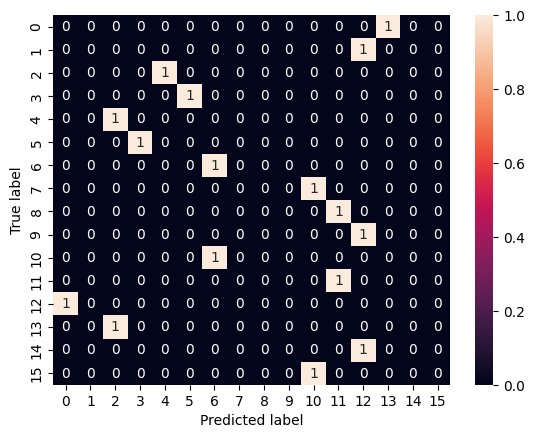

In [44]:
# Get predictions for more details analysis
y_pred = pipeline.predict(X_test)

heatmap_labels = sorted( y_test.unique()  )

print("=======CLASSIFICATION REPORT ==============")
cr = classification_report( y_test, y_pred , zero_division=0)
print( cr  )

print("=======CONFUSION MATRIX ==============")
cm = confusion_matrix( y_test, y_pred, labels=heatmap_labels )
print( cm  )

sns.heatmap( cm, annot=True, fmt='d', xticklabels=heatmap_labels,  yticklabels=heatmap_labels  )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [45]:
# Very bad performance with best model/params, but with train test/split -> dataset is very small.